In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torch.nn.functional as F
from tensorboard import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import  precision_score, recall_score, f1_score,  roc_auc_score, average_precision_score, precision_recall_curve

In [2]:
# # I trained the CNN model in Keras framework already, I am going to build CNN in PyTorch framework to see, could I get better result.
# I will use the same code structure for prepring data in here as in Keras notebook.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# Loading the DSs 
df_test = pd.read_csv('cleaned_datatest.csv')
df_val = pd.read_csv('datavalidation.csv')
df_train = pd.read_csv('datatraining.csv')
df_train.head()

,Temperature,Humidity,CO2,Occupancy,weekend,tod_sin,tod_cos
0,23.18,27.2720,721.25,1,0,-0.999229,-0.039260
1,23.15,27.2675,714.00,1,0,-0.999229,-0.039260
2,23.15,27.2450,713.50,1,0,-0.999534,-0.030539
3,23.15,27.2000,708.25,1,0,-0.999657,-0.026177
4,23.10,27.2000,704.50,1,0,-0.999762,-0.021815


In [5]:
print(df_train.duplicated().sum())
print(df_val.duplicated().sum())
print(df_test.duplicated().sum())

1
0
5


In [6]:
for df in [df_train, df_test]:
    df.drop_duplicates(inplace=True)

In [7]:
# Preparing data for CNN model,
target = 'Occupancy'
features = ["Temperature", "Humidity", "CO2", "weekend", "tod_sin", "tod_cos"]

X_train = df_train[features].values
y_train = df_train[target].values.astype(int)

X_val = df_val[features].values
y_val = df_val[target].values.astype(int)

X_test = df_test[features].values
y_test = df_test[target].values.astype(int)

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Scaling the features, I will fit only the train  DS
# Because the weekend is binary and tod_sin, tod_cos are already normialized, to -1 , 1. So I will Standardize the continuous features.
scaler = StandardScaler()
X_train_scaled[:, 0:3] = scaler.fit_transform(X_train_scaled[:, 0:3])

# transforming val and test DS 
X_val_scaled[:, 0:3] = scaler.transform(X_val_scaled[:, 0:3])
X_test_scaled[:, 0:3]= scaler.transform(X_test_scaled[:, 0:3])

print("Train:", X_train_scaled.shape, y_train.shape)
print("Val:", X_val_scaled.shape, y_val.shape)
print("Test:", X_test_scaled.shape, y_test.shape)

Train: (8117, 6) (8117,)
Val: (2663, 6) (2663,)
Test: (9720, 6) (9720,)


In [8]:
# Checking the weekend and tod_sin, tod_cos. 
print("weekend unique:", np.unique(X_train_scaled[:,3]))
print("tod_sin min/max:", X_train_scaled[:,4].min(), X_train_scaled[:,4].max())
print("tod_cos min/max:", X_train_scaled[:,5].min(), X_train_scaled[:,5].max())

weekend unique: [0. 1.]
tod_sin min/max: -1.0 1.0
tod_cos min/max: -1.0 1.0


In [9]:
# MAKING SEQUENCES:
# The CNN model for time series, needs sequences as input 
# I will create windows of minutes that the model will predict right after the window, the next minute

# Creating function
window_size = 60
step_ahead = 1
def windows_time(X, y, window_size = None, step_ahead = None):
   # I will creaate two lists for storing  features and the target
   # The end should start the a window
   X_windows = []
   y_windows = []
   last_start = len(X) - window_size - step_ahead + 1
   for start in range(last_start):
        end = start + window_size
        X_windows.append(X[start:end])                  
        y_windows.append(y[end + step_ahead - 1])      
   return np.array(X_windows), np.array(y_windows)

X_train_window, y_train_window = windows_time(X_train_scaled, y_train, window_size, step_ahead)
X_val_window, y_val_window = windows_time(X_val_scaled, y_val, window_size, step_ahead)
X_test_window, y_test_window = windows_time(X_test_scaled, y_test, window_size, step_ahead)

print("Train windows:", X_train_window.shape, y_train_window.shape)
print("Val windows:", X_val_window.shape,y_val_window.shape)
print("Test windows:", X_test_window.shape, y_test_window.shape)

Train windows: (8057, 60, 6) (8057,)
Val windows: (2603, 60, 6) (2603,)
Test windows: (9660, 60, 6) (9660,)


In [10]:
X_train_tensor = torch.tensor(X_train_window, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_window, dtype=torch.long) 
X_val_tensor = torch.tensor(X_val_window, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_window, dtype=torch.long)
X_test_tensor= torch.tensor(X_test_window, dtype=torch.float32)
y_test_tensor= torch.tensor(y_test_window, dtype=torch.long)

In [11]:
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# I nned to see shape of one batch
for X_batch, y_batch in train_loader:
    print(f"Batch input shape: {X_batch.shape}") 
    print(f"Batch target shape: {y_batch.shape}")
    break  
# In forward function, I will switch input shape and sequence lemght

Batch input shape: torch.Size([128, 60, 6])
Batch target shape: torch.Size([128])


<h2><center>CNN Architecture<h2>

In [13]:
# I am going to build 1D CNN for time series classification. Same issue here, the imbalanced rate is not same for each DS.
# First I need to create a convolutional block class 
# Second, I am going to create the CNN model. 

In [14]:
class ConnvectionalBlocks(nn.Module):
    def __init__(self, Input_channel, Output_channel, kernel_size=3, dropout_rate=0.1):
        super().__init__()
        # First convolutional layer:
        # the constrcutor will have input channel, output channel, kernel size and dropout rate as parameters.
        self.conv1 = nn.Conv1d(in_channels=Input_channel, out_channels=Output_channel, kernel_size=kernel_size, padding= kernel_size//2)
        # Batch normalization:
        self.bn1 = nn.BatchNorm1d(Output_channel)
        self.drop = nn.Dropout1d(p=dropout_rate)


# OPERATION FUNCTION:
# Extrating the local patters 
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop(x)
        return x

#     
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional block
        self.conv_block1 = ConnvectionalBlocks(Input_channel=6, Output_channel=32, kernel_size=5, dropout_rate=0.1)
        # Second convolutional block
        self.conv_block2 = ConnvectionalBlocks(Input_channel=32, Output_channel= 32, kernel_size=4, dropout_rate=0.1)
        # Max pooling, to halve the lengh
        self.pool1  = nn.MaxPool1d(kernel_size=2)


        # Third convolutional block
        self.conv_block3 = ConnvectionalBlocks(Input_channel=32, Output_channel=64, kernel_size=5, dropout_rate=0.1)
        # Fourth convolutional block
        self.conv_block4 = ConnvectionalBlocks(Input_channel=64, Output_channel=64, kernel_size=4, dropout_rate=0.1)
        # second Max pooling
        self.pool2  = nn.MaxPool1d(kernel_size=2)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        # Fully connected layer
        self.fc1 = nn.Linear(64, 1)


# Operation function:   
    def forward(self, x):
        # Switching the input index
        x = x.transpose(1, 2)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.pool1(x)

        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.pool2(x)

        x = self.global_avg_pool(x)
        x = x.squeeze(-1)
        logits = self.fc1(x)
        return logits

model = CNNModel().to(device)


# Sources :
# https://medium.com/@ugamakelechi501/building-a-convolutional-neural-network-cnn-from-scratch-with-pytorch-eca3ffdcf2ff
# https://www.dkneup.com/blog/cnn-time-series-forecasting-in-tensorflow-pytorch
# https://medium.com/%40santi.pdp/how-pytorch-transposed-convs1d-work-a7adac63c4a5

# For debugging, I used the Qwen3 Max model. 

In [15]:
# As in the Keras notebook, calculating class weights does not work well here.
#The gap between training and validation loss is big because the Occupancy distribution is different in each dataset.
# The model is trained on the train dataset distribution but evaluated on the validation dataset distribution.

#I should go with the same approach as in the Keras notebook: use Focal Loss.

In [16]:
# Creating the Focal Loss class:
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        targets = targets.float()
        binary_class_loss= F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        probability_true_class = torch.exp(-binary_class_loss)
        loss = (1- probability_true_class).pow(self.gamma) * binary_class_loss
        return loss.mean()
criterion = FocalLoss(gamma=3.0)

# The loss class, calculates loss with 1 class's weight.

# Sources:
# https://discuss.pytorch.org/t/implementing-focal-loss-for-a-binary-classification-problem/128664
# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001)
# If val loss does not improve for 5 epochs, lr is going to be cut by half
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='min' )
print('Optimizer:', optimizer)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-06
)


<h2><center>Training Loop<h2>

In [ ]:
# Function to calculate F2 score
def f2_score(y_true, y_pred):
    from sklearn.metrics import fbeta_score
    return fbeta_score(y_true, y_pred,beta=2.0, zero_division=0)

In [ ]:
epochs = 50
best_val_loss =float('inf')
best_f2 = 0.0
patience = 8
patience_counter = 0
best_model_state= None


for epoch in range(1, epochs+1):
    model.train() 
    train_loss_sum= 0
    correct_predictions = 0
    train_total= 0
    
    for X_batch,y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch =y_batch.to(device)

        optimizer.zero_grad()
        outputs= model(X_batch)            
        loss = criterion(outputs.squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()*X_batch.size(0)
        predictions =(torch.sigmoid(outputs.squeeze(1))>= 0.5).long()
        correct_predictions += (predictions==y_batch).sum().item()
        train_total += y_batch.size(0)

    train_loss= train_loss_sum / len(train_dataset)
    train_accuracy= correct_predictions/train_total

# EVALUATION PHASE:
    model.eval()
    val_loss_sum = 0.0
    val_probabilities= []
    val_predictions=[]
    val_actual_class=[]
      
    with torch.no_grad():  
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits= model(X_batch)
            loss= criterion(logits.squeeze(1), y_batch.float())
            val_loss_sum += loss.item()*X_batch.size(0)

            probs=torch.sigmoid(logits.squeeze(1))
            preds=(probs >=0.5).to(torch.int64)

            val_predictions.extend(preds.tolist())
            val_probabilities.extend(probs.tolist())  
            val_actual_class.extend(y_batch.tolist())
            
    val_loss= val_loss_sum/len(val_dataset)

# COMPUTE METRICS:
    val_ap = average_precision_score(val_actual_class, val_probabilities)
    val_recall= recall_score(val_actual_class, val_predictions, zero_division=0)
    val_precision =precision_score(val_actual_class,val_predictions, zero_division=0)
    val_f2 = f2_score(val_actual_class, val_predictions)



    current_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(val_loss)

    print(f"Epoch {epoch:>3}: "
          f"TrLoss {train_loss:.4f},VaLoss {val_loss:.4f}, "
          f"Acc {train_accuracy:.4f},AP {val_ap:.4f}, "
          f"Rec {val_recall:.4f}, Prec {val_precision:.4f}, F2 {val_f2:.4f}, "
          f"LR {current_lr:.6f}")

    if val_f2 > best_f2:
        best_f2 = val_f2
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state= model.state_dict().copy()
        print(f"Model saved (F2:{val_f2:.4f})")
    else:
        patience_counter+= 1
        if patience_counter>=patience:
            print("Early stopping triggered.")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n Loaded best model with F2: {best_f2:.4f}")
else:
    print("\nThe best model is not saved.")

# Source: https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html   
# For debugging, I used the Qwen3 Max

Epoch   1: TrLoss 0.0311, VaLoss 0.0254, Acc 0.9178, AP 0.9121, Rec 0.9627, Prec 0.8558, F2 0.9392, LR 0.001000
Model saved (F2:0.9392)
Epoch   2: TrLoss 0.0169, VaLoss 0.0210, Acc 0.9533, AP 0.9466, Rec 0.9693, Prec 0.8929, F2 0.9530, LR 0.001000
Model saved (F2:0.9530)
Epoch   3: TrLoss 0.0147, VaLoss 0.0203, Acc 0.9605, AP 0.9598, Rec 0.9430, Prec 0.8903, F2 0.9319, LR 0.001000
Epoch   4: TrLoss 0.0139, VaLoss 0.0195, Acc 0.9598, AP 0.9627, Rec 0.9331, Prec 0.8911, F2 0.9244, LR 0.001000
Epoch   5: TrLoss 0.0130, VaLoss 0.0197, Acc 0.9626, AP 0.9579, Rec 0.9221, Prec 0.9161, F2 0.9209, LR 0.001000
Epoch   6: TrLoss 0.0119, VaLoss 0.0164, Acc 0.9651, AP 0.9695, Rec 0.9320, Prec 0.9372, F2 0.9330, LR 0.001000
Epoch   7: TrLoss 0.0119, VaLoss 0.0175, Acc 0.9634, AP 0.9574, Rec 0.9035, Prec 0.9364, F2 0.9099, LR 0.001000
Epoch   8: TrLoss 0.0121, VaLoss 0.0280, Acc 0.9664, AP 0.9348, Rec 0.9156, Prec 0.8599, F2 0.9039, LR 0.001000
Epoch   9: TrLoss 0.0120, VaLoss 0.0176, Acc 0.9662, AP 

In [ ]:
# Defening threshold:
# To catch better the 1 class, I am going to find the optimized threshold based on F2 score.

model.eval()
probabilities =[]
true_labels= []
with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        batch_features = batch_features.to(device)
        batch_logits= model(batch_features)
        batch_probabilities = torch.sigmoid(batch_logits.squeeze(1))
        probabilities.extend(batch_probabilities.cpu().tolist())
        true_labels.extend(batch_labels.tolist())
probabilities_array = np.array(probabilities)
true_labels_array= np.array(true_labels)

best_threshold = 0.5
best_f2_score = 0.0

threshold_candidates=[0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

for current_threshold in threshold_candidates:
    predictions=(probabilities_array >= current_threshold).astype(int)
    precision=precision_score(true_labels_array, predictions, zero_division=0)
    recall= recall_score(true_labels_array, predictions,zero_division=0)
    f2_score =(1 + 4) * (precision * recall)/(4*precision+recall+0.00000000001)   
    if f2_score > best_f2_score:
        best_f2_score= f2_score
        best_threshold = current_threshold
    
    print(f"{current_threshold:<12.2f} {precision:<12.4f} {recall:<12.4f} {f2_score:<12.4f}")
print("-"*60)
print(f"Optimal threshold:{best_threshold}")

# I could  implement this code in validation loop, this makes redundancy in my code.
# Source" https://medium.com/%40douglaspsteen/precision-recall-curves-d32e5b290248
# https://scikit-learn.org/1.4/modules/model_evaluation.html?
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/?
# For debugging, I used Qwen Max

0.30         0.8268       1.0000       0.9598      
0.35         0.8539       1.0000       0.9669      
0.40         0.8758       0.9978       0.9708      
0.45         0.8902       0.9868       0.9659      
0.50         0.9216       0.9024       0.9062      
0.55         0.9333       0.8136       0.8350      
0.60         0.9501       0.7303       0.7657      
------------------------------------------------------------
Optimal threshold: 0.4


Test Loss: 0.05
Test AP Score: 0.87

Confusion Matrix:


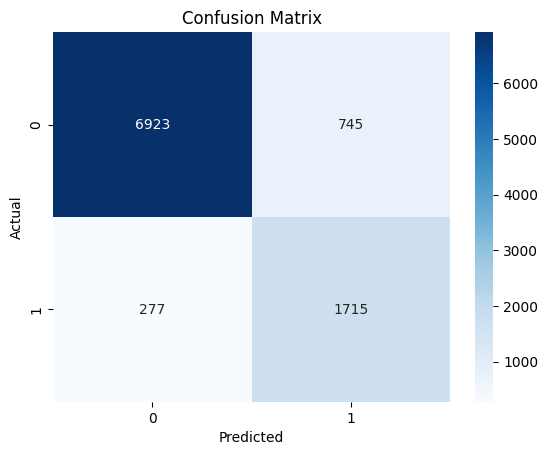


Classification Report:
              precision    recall  f1-score   support

No Occupancy       0.96      0.90      0.93      7668
   Occupancy       0.70      0.86      0.77      1992

    accuracy                           0.89      9660
   macro avg       0.83      0.88      0.85      9660
weighted avg       0.91      0.89      0.90      9660



In [ ]:
# Evaluation on the test DS:
model.eval()
test_preds = []
test_probs = []  
test_targets = []
test_loss_sum = 0.0

with torch.no_grad():
    for X_batch,y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch=y_batch.to(device)
        
        logits= model(X_batch)
        loss =criterion(logits.squeeze(1),y_batch.float())
        probs =torch.sigmoid(logits.squeeze(1))
       
        preds =(probs>= best_threshold).to(torch.int64)
        test_loss_sum+=loss.item()*X_batch.size(0)

        test_preds.extend(preds.tolist())
        test_probs.extend(probs.tolist())
        test_targets.extend(y_batch.tolist())

test_loss=test_loss_sum/len(test_dataset)
test_preds = np.array(test_preds)
test_probs=np.array(test_probs)
test_targets= np.array(test_targets)

print(f"Test Loss: {test_loss:.2f}")
print(f"Test AP Score: {average_precision_score(test_targets,test_probs):.2f}")

# Confusion Matrix
Confusion_matrix = confusion_matrix(test_targets, test_preds)
print("\nConfusion Matrix:")
sns.heatmap(Confusion_matrix,annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_targets, test_preds, target_names=['No Occupancy', 'Occupancy'],zero_division=0))


In [ ]:
# In this Pytorch, I got better prediction's accuracy and balance  than Keras, but the problem is that the actual catches rate is lower than Keras.
# My model misses more actual cases for occupancy.

# One solution can be using resampling or oversampling, to make the distribution more similar.
# Usually the val loss is a lot higher than train loss, which means the model is overfitting, but in my case, each DS has different distribution.


# When I played with gamma parameter in Focal Loss class, I noticed that when gamma is higher, the recall becomes higher for 1 
# But precision becames lower and also all the metrics for class 0 became lower. 
# But when gamma is lower, the precision becomes higher for class 1, but recall becomes lower. Also  all the metrics for class 0 became better.

# I asked GPT and what  I learned: 
# When the gamma is higher, the model puts more focus on 1 class and becomes good to detects 1 that is why the recall is higher
# while the model is fucusing on 1, it kind of ignores 0. 
#  I went for gamma = 3 which is not too high and not too low.



# I picked up higher values for kernal size that model can see longet pattern.
# the recall and f1 score are improved, the model can catch the 1 classes even with low confident.  
